<a href="https://colab.research.google.com/github/mswaringen/aml_food/blob/master/Another2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
from torch import optim
import torch.nn.functional as F
from torchvision import datasets

from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# download and unzip locally

downzip=True

if downzip:
  !mkdir data
  %cd data
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV" -O final-project-food-recognition-challenge.zip && rm -rf /tmp/cookies.txt
  !unzip final-project-food-recognition-challenge.zip
  %cd ..
  !mkdir outputs

mkdir: cannot create directory ‘data’: File exists
/content/data
--2020-12-05 00:25:51--  https://docs.google.com/uc?export=download&confirm=tA9z&id=1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV
Resolving docs.google.com (docs.google.com)... 173.194.203.100, 173.194.203.101, 173.194.203.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.203.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-60-docs.googleusercontent.com/docs/securesc/ng8417lpnj4mdtn4c0vk20gj0obpvps1/441ne7ful4qufdghgm3493qe1to6ftmh/1607127900000/10490392775048702533/04099668088604138981Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download [following]
--2020-12-05 00:25:51--  https://doc-0o-60-docs.googleusercontent.com/docs/securesc/ng8417lpnj4mdtn4c0vk20gj0obpvps1/441ne7ful4qufdghgm3493qe1to6ftmh/1607127900000/10490392775048702533/04099668088604138981Z/1Io_dwM_UujedpHWjRvMpZQ5mtOoeGTDV?e=download
Resolving doc-0o-60-docs.googleusercontent.com (doc-0o-60-docs.google

In [25]:
class CatsAndDogsDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [26]:
class CNN(nn.Module):
    def __init__(self, train_CNN=False, num_classes=1):
        super(CNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        features = self.inception(images)
        return self.sigmoid(self.dropout(self.relu(features))).squeeze(1)

In [27]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [28]:
# num_epochs = 6
learning_rate = 0.00001
train_CNN = False
batch_size = 512
shuffle = True
pin_memory = True
num_workers = 1

dataset = CatsAndDogsDataset("data/train_set/train_set","data/train_labels.csv",transform=transform)

train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

train_set, validation_set = torch.utils.data.random_split(dataset,[train_size,val_size])
trainloader = DataLoader(dataset=train_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers,pin_memory=pin_memory)
testloader = DataLoader(dataset=validation_set, shuffle=shuffle, batch_size=batch_size,num_workers=num_workers, pin_memory=pin_memory)



In [29]:
# model = CNN().to(device)

# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for name, param in model.inception.named_parameters():
#     if "fc.weight" in name or "fc.bias" in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = train_CNN

In [30]:
model = models.resnet50(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

RuntimeError: ignored

In [ ]:
epochs = 1
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.long().to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

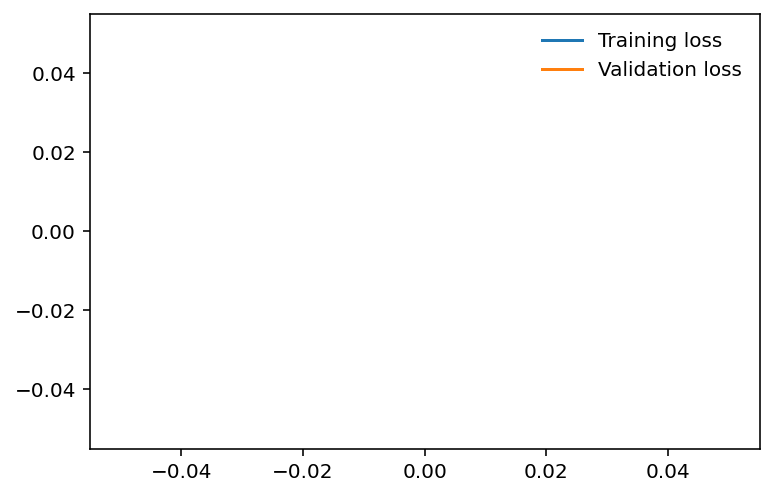

In [31]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
for epoch in range(2):
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        print(inputs)